## Created on Thr Aug 15 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

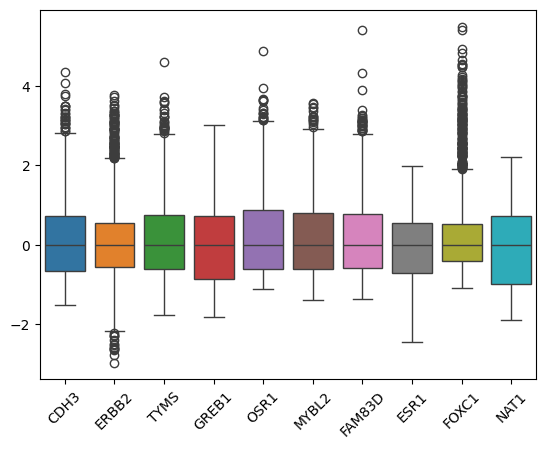

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("X_train_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

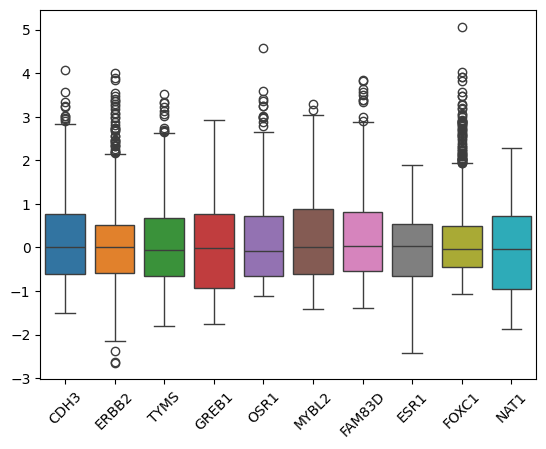

In [3]:
# Load X_test gene expression dataset.
X_test = pd.read_csv("X_test_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test)
plt.xticks(rotation = 45)

In [4]:
# Load PAM50 subtype dataset.
target = pd.read_csv("GPL11154_PAM50.csv", sep = "\t", index_col = "geo_accession")
target.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [5]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [6]:
# Load test PAM50 subtype dataset.
y_test = target.loc[X_test.index.tolist(), :]
y_test.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2530931,LumB
GSM2528314,Basal
GSM2528222,Basal
GSM2531033,LumA
GSM2529552,LumB


In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)
y_test_encoder = encoder.transform(y_test)

# Create series.
y_train = pd.Series(y_train_encoder, index = y_train.index)
y_test = pd.Series(y_test_encoder, index = y_test.index)

In [8]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

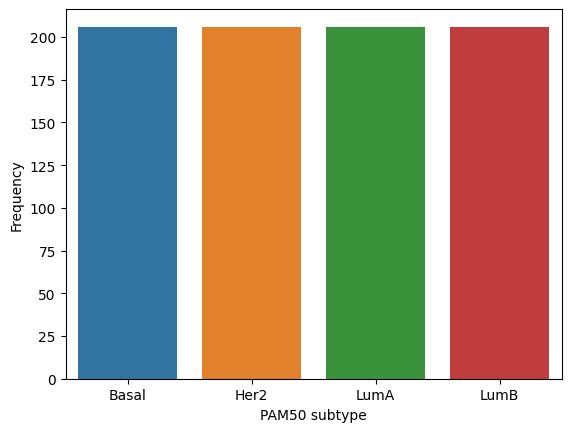

In [9]:
# Check count for each class in the training data.
class_counts = y_res.groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

### Compare model performance between original and undersampled data.

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
clf = GaussianNB()
precision = make_scorer(precision_score, average = 'macro', zero_division = 0)
recall = make_scorer(recall_score, average = 'macro', zero_division = 0)

scoring = {"accuracy" : "accuracy",
           "precision" : precision,
           "recall" : recall,
           "f1-score" : "f1_macro",
           "auc" : "roc_auc_ovr"}

origianl_score = cross_validate(clf, X_train, y_train, cv = cv, scoring = scoring, return_train_score = True)
undersample_score = cross_validate(clf, X_res, y_res, cv = cv, scoring = scoring, return_train_score = True)

In [11]:
print("Mean train accuracy (original) =", np.mean(origianl_score["train_accuracy"]), "±", np.std(origianl_score["train_accuracy"]))
print("Mean validation accuracy (original) =", np.mean(origianl_score["test_accuracy"]), "±", np.std(origianl_score["test_accuracy"]), "\n")
print("Mean train precision (original) =", np.mean(origianl_score["train_precision"]), "±", np.std(origianl_score["train_precision"]))
print("Mean validation precision (original) =", np.mean(origianl_score["test_precision"]), "±", np.std(origianl_score["test_precision"]), "\n")
print("Mean train recall (original) =", np.mean(origianl_score["train_recall"]), "±", np.std(origianl_score["train_recall"]))
print("Mean validation recall (original) =", np.mean(origianl_score["test_recall"]), "±", np.std(origianl_score["test_recall"]), "\n")
print("Mean train F1-score (original) =", np.mean(origianl_score["train_f1-score"]), "±", np.std(origianl_score["train_f1-score"]))
print("Mean validation F1-score (original) =", np.mean(origianl_score["test_f1-score"]), "±", np.std(origianl_score["test_f1-score"]), "\n")
print("Mean train AUROC (original) =", np.mean(origianl_score["train_auc"]), "±", np.std(origianl_score["train_auc"]))
print("Mean validation AUROC (original) =", np.mean(origianl_score["test_auc"]), "±", np.std(origianl_score["test_auc"]), "\n")

Mean train accuracy (original) = 0.8618187917040013 ± 0.002564760675723749
Mean validation accuracy (original) = 0.858276534373164 ± 0.023146337400031837 

Mean train precision (original) = 0.8567686773998004 ± 0.0038117129858905164
Mean validation precision (original) = 0.8552527676116309 ± 0.029473473204500056 

Mean train recall (original) = 0.8380484856245866 ± 0.0039468565030450565
Mean validation recall (original) = 0.8334438711527885 ± 0.029731439685132692 

Mean train F1-score (original) = 0.8470342744120594 ± 0.0036061903681011425
Mean validation F1-score (original) = 0.842106532905475 ± 0.02844931138022352 

Mean train AUROC (original) = 0.9705450467785535 ± 0.0008340963319889949
Mean validation AUROC (original) = 0.9688454865691817 ± 0.00833544407203771 



In [12]:
print("Mean train accuracy (undersampled) =", np.mean(undersample_score["train_accuracy"]), "±", np.std(undersample_score["train_accuracy"]))
print("Mean validation accuracy (undersampled) =", np.mean(undersample_score["test_accuracy"]), "±", np.std(undersample_score["test_accuracy"]), "\n")
print("Mean train precision (undersampled) =", np.mean(undersample_score["train_precision"]), "±", np.std(undersample_score["train_precision"]))
print("Mean validation precision (undersampled) =", np.mean(undersample_score["test_precision"]), "±", np.std(undersample_score["test_precision"]), "\n")
print("Mean train recall (undersampled) =", np.mean(undersample_score["train_recall"]), "±", np.std(undersample_score["train_recall"]))
print("Mean validation recall (undersampled) =", np.mean(undersample_score["test_recall"]), "±", np.std(undersample_score["test_recall"]), "\n")
print("Mean train F1-score (undersampled) =", np.mean(undersample_score["train_f1-score"]), "±", np.std(undersample_score["train_f1-score"]))
print("Mean validation F1-score (undersampled) =", np.mean(undersample_score["test_f1-score"]), "±", np.std(undersample_score["test_f1-score"]), "\n")
print("Mean train AUROC (undersampled) =", np.mean(undersample_score["train_auc"]), "±", np.std(undersample_score["train_auc"]))
print("Mean validation AUROC (undersampled) =", np.mean(undersample_score["test_auc"]), "±", np.std(undersample_score["test_auc"]), "\n")

Mean train accuracy (undersampled) = 0.8354364139667019 ± 0.005926820175104688
Mean validation accuracy (undersampled) = 0.825997649133118 ± 0.039415759931508046 

Mean train precision (undersampled) = 0.8370170201201086 ± 0.005835326520011667
Mean validation precision (undersampled) = 0.8322524333405035 ± 0.03925919234543873 

Mean train recall (undersampled) = 0.8354365010171463 ± 0.0059313785750444974
Mean validation recall (undersampled) = 0.8262440476190477 ± 0.03933772666214429 

Mean train F1-score (undersampled) = 0.8358192779074695 ± 0.005928127199575911
Mean validation F1-score (undersampled) = 0.8259587634790643 ± 0.03949054842365004 

Mean train AUROC (undersampled) = 0.9653810735703924 ± 0.0012615986991589142
Mean validation AUROC (undersampled) = 0.962203306388658 ± 0.014374124355205506 



###  Hyperparameter tuning using GridSearchCV

In [13]:
hyperparameters = {'var_smoothing': [1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]} 

optimizer = GridSearchCV(clf, hyperparameters, cv = cv, scoring = scoring, 
                         n_jobs = 60, return_train_score = True, refit = "accuracy")
best_model = optimizer.fit(X_train, y_train)

In [14]:
print('가장 좋은 var_smoothing 값:', best_model.best_estimator_.get_params()['var_smoothing'])
print("가장 좋은 Score :",best_model.best_score_)

가장 좋은 var_smoothing 값: 0.0001
가장 좋은 Score : 0.858276534373164


In [15]:
# Make GridSearCV result.
CV_result = pd.DataFrame(best_model.cv_results_)
select_columns = ['params',
                  'mean_train_accuracy', 'std_train_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
                  'mean_train_precision', 'std_train_precision', 'mean_test_precision', 'std_test_precision',
                  'mean_train_recall', 'std_train_recall', 'mean_test_recall', 'std_test_recall',
                  'mean_train_f1-score', 'std_train_f1-score', 'mean_test_f1-score', 'std_test_f1-score',
                  'mean_train_auc', 'std_train_auc', 'mean_test_auc', 'std_test_auc']

Final_GRID_result = CV_result.loc[:, select_columns].sort_values(by = 'mean_test_accuracy', ascending = False).reset_index(drop = True).transpose()
Final_GRID_result

,0,1,2,3,4,5
params,{'var_smoothing': 0.0001},{'var_smoothing': 1e-06},{'var_smoothing': 1e-08},{'var_smoothing': 1e-10},{'var_smoothing': 1e-12},{'var_smoothing': 0.01}
mean_train_accuracy,0.861819,0.861819,0.861819,0.861819,0.861819,0.861796
std_train_accuracy,0.002558,0.002565,0.002565,0.002565,0.002565,0.002748
mean_test_accuracy,0.858277,0.858277,0.858277,0.858277,0.858277,0.858225
std_test_accuracy,0.023146,0.023146,0.023146,0.023146,0.023146,0.023407
mean_train_precision,0.856772,0.856769,0.856769,0.856769,0.856769,0.85756
std_train_precision,0.003801,0.003812,0.003812,0.003812,0.003812,0.003885
mean_test_precision,0.855253,0.855253,0.855253,0.855253,0.855253,0.856261
std_test_precision,0.029473,0.029473,0.029473,0.029473,0.029473,0.03008
mean_train_recall,0.838056,0.838048,0.838048,0.838048,0.838048,0.83742


### Model evaluation using hyperparameter

In [16]:
# Model fitting and prediction.
model = best_model.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [17]:
# Classification report
print(classification_report(y_test, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.93      0.86      0.89        92
        Her2       0.79      0.76      0.78        89
        LumA       0.89      0.89      0.89       450
        LumB       0.73      0.77      0.75       200

    accuracy                           0.84       831
   macro avg       0.84      0.82      0.83       831
weighted avg       0.85      0.84      0.85       831



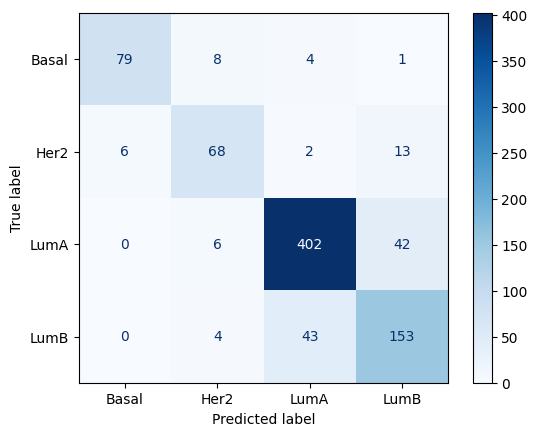

In [18]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

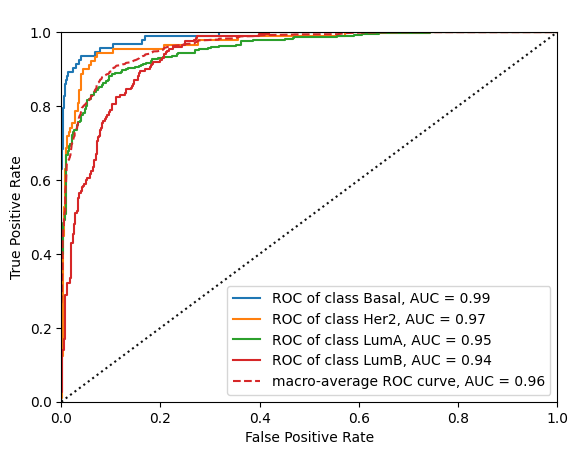

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [19]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

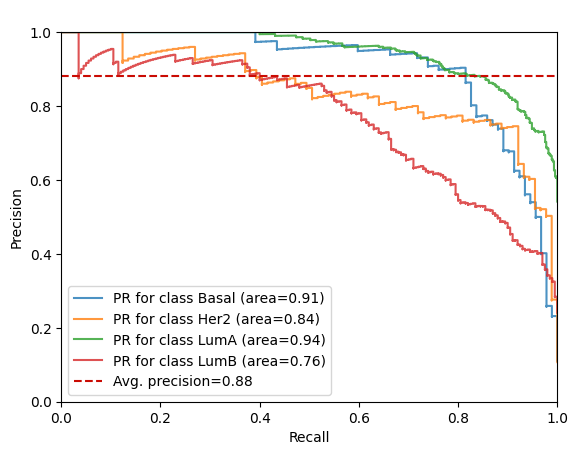

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [20]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, per_class = True, classes = ["Basal", "Her2", "LumA", "LumB"], title = " ")
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

In [21]:
# Accuracy
accuracy_score(y_test, y_pred)

0.8447653429602888

In [22]:
# Macro average precision
precision_score(y_test, y_pred, average = "macro")

0.8358798513203912

In [23]:
# Macro average recall
recall_score(y_test, y_pred, average = "macro")

0.8202684823318679

In [24]:
# Macro average F1 score
f1_score(y_test, y_pred, average = "macro")

0.827576581485134

In [25]:
# Macro average AUROC
roc_auc_score(y_test, y_pred_proba, multi_class = "ovr", average = "macro")

0.9627974435614778